In [ ]:
!pip install pygame

# Construimos el Environment


In [ ]:
# set SDL to use the dummy NULL video driver,
#   so it doesn't need a windowing system.
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [23]:
import gym
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import matplotlib.pyplot as plt
import pygame
from pygame.locals import QUIT

import cv2
from google.colab.patches import cv2_imshow
from google.colab import output
import time
import os, sys

# Asegúrate de que el directorio exista
os.makedirs("qtables", exist_ok=True)
os.makedirs("images", exist_ok=True)

class RocketPole(Env):
    def __init__(self):
        self.action_space = Discrete(3)
        self.observation_space = Box(low=np.array([0, -np.pi]), high=np.array([np.pi, np.pi]))
        self.reset()
        self.mass = 40.0
        self.length = 3.0
        self.force_mag = 1.0
        pygame.init()
        pygame.font.init()  # Inicializamos pygame.font
        self.font = pygame.font.SysFont('Arial', 24)
        self.screen_width = 800
        self.screen_height = 600
        self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
        pygame.display.set_caption('RocketPole Simulation')
        self.clock = pygame.time.Clock()
        #Torque de Control
        self.torque = 500

    def step(self, action):
        self.state = self.updateState(action)
        self.tiempo_de_vuelo -= 0.0005
        reward = self.calculateReward(self.state)
        done = self.tiempo_de_vuelo <= 0
        if self.state[0] < ((7/15)*np.pi) or self.state[0] > ((8/15)*np.pi):
            done = True
        self.state[0] += random.uniform(-np.pi/180, np.pi/180)
        info = {}
        return self.state, reward, done, info

    def calculateReward(self, state):
        angle, angular_velocity = state

        # Recompensa por la estabilidad angular
        angle_error = abs(angle - np.pi / 2)
        normalized_angle_error = angle_error / (np.pi / 2)
        angle_reward = 1 - normalized_angle_error

        # Penalización por la velocidad angular alta
        max_angular_velocity = np.pi  # Suponemos que la velocidad angular está en el rango [-pi, pi]
        normalized_angular_velocity = abs(angular_velocity) / max_angular_velocity
        angular_velocity_penalty = normalized_angular_velocity

        # Recompensa por mantener el tiempo de vuelo
        time_reward = 0.01  # Pequeña recompensa por cada paso

        # Penalización por salirse del rango aceptable
        if (angle < (7/15) * np.pi) or (angle > (8/15) * np.pi):
            range_penalty = -1  # Penalización severa por salirse del rango
        else:
            range_penalty = 0

        # Calculamos la recompensa total
        reward = angle_reward - angular_velocity_penalty + time_reward + range_penalty

        return reward


    def reset(self):
        theta = (np.pi / 2) + random.uniform(-np.pi / 90, np.pi / 90)
        theta_dot = 0.0
        self.state = np.array([theta, theta_dot])
        self.tiempo_de_vuelo = 2
        return self.state

    def updateState(self, action):
        g = 9.81  # aceleración de la gravedad
        dt = 0.05  # intervalo de tiempo

        theta, theta_dot = self.state

        # Acción del cohete
        force = self.force_mag * (action - 1)
        torque = self.torque

        # Cálculo de la velocidad angular
        L = self.length
        r_cg = L / 2  # Asumimos que el centro de gravedad está a la mitad del cohete
        I_cg = (1/12) * self.mass * L**2  # Momento de inercia del cohete alrededor de su centro de gravedad
        m_at = (self.mass * L**2)/4
        # Aceleración angular (según la ecuación diferencial derivada)
        theta_dot_dot =(-1)*force*((-1)*torque + self.mass * g * r_cg * np.sin(theta)) / (I_cg + m_at)

        # Actualizamos la velocidad angular
        new_theta_dot = theta_dot + theta_dot_dot * dt

        # Actualizamos la posición angular
        new_theta = theta + new_theta_dot * dt

        # Limitamos el ángulo entre 0 y pi
        new_theta = np.clip(new_theta, 0, np.pi)

        new_state = np.array([new_theta, new_theta_dot])

        return new_state
    def update_episode_action(self, episode, action):
        self.episode = episode
        self.action = action
    def render(self):
        for event in pygame.event.get():
            if event.type == QUIT:
                pygame.quit()
                return

        self.screen.fill((255, 255, 255))
        theta = self.state[0]
        angle = theta
        center_x = self.screen_width / 2
        center_y = self.screen_height / 2
        bar_length = self.length * 90
        end_x = center_x + bar_length * np.cos(angle)
        end_y = center_y - bar_length * np.sin(angle)
        pygame.draw.line(self.screen, (255, 0, 0), (center_x, center_y), (end_x, end_y), 5)

        # Renderizar el texto del episodio y la acción
        text_surface = self.font.render(f"Episodio: {self.episode} | Acción: {self.action}", True, (0, 0, 0))
        self.screen.blit(text_surface, (10, self.screen_height - 30))

        pygame.display.flip()
        view = pygame.surfarray.array3d(self.screen)
        view = view.transpose([1, 0, 2])
        img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
        cv2_imshow(img_bgr)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            return
        time.sleep(0.1)
        cv2.destroyAllWindows()
        output.clear()


In [24]:
# Inicializamos parámetros y estructuras de datos
alpha = 0.1
gamma = 0.99
epsilon = 0.1
num_episodes = 10000
env = RocketPole()
q_table = np.zeros((50, 50, env.action_space.n))
rewards_per_episode = []
epsilons = []
q_values_mean = []

ep_rewards = []
aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}
STATS_EVERY = 100

os.makedirs('qtables', exist_ok=True)

def discretize_state(state):
    theta, theta_dot = state
    theta_bin = int((theta / np.pi) * 50)
    theta_dot_bin = int(((theta_dot + np.pi) / (2 * np.pi)) * 50)
    return theta_bin, theta_dot_bin

for episode in range(num_episodes):
    episode_reward = 0
    state = env.reset()
    state_discrete = discretize_state(state)
    done = False

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state_discrete])

        next_state, reward, done, info = env.step(action)
        env.update_episode_action(episode, action)
        #env.render()
        next_state_discrete = discretize_state(next_state)

        best_next_action = np.argmax(q_table[next_state_discrete])
        td_target = reward + gamma * q_table[next_state_discrete][best_next_action]
        td_error = td_target - q_table[state_discrete][action]
        q_table[state_discrete][action] += alpha * td_error

        state_discrete = next_state_discrete
        episode_reward += reward

    ep_rewards.append(episode_reward)

    if not episode % STATS_EVERY:
        average_reward = sum(ep_rewards[-STATS_EVERY:])/STATS_EVERY
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(average_reward)
        aggr_ep_rewards['max'].append(max(ep_rewards[-STATS_EVERY:]))
        aggr_ep_rewards['min'].append(min(ep_rewards[-STATS_EVERY:]))
        print(f"Episode: {episode:>5d}, average reward: {average_reward:>4.1f}, current epsilon: {epsilon:>1.2f}")

    if episode % 10 == 0:
        np.save(f"qtables/{episode}-qtable.npy", q_table)

    epsilon = max(0.01, epsilon * 0.995)

Episode:     0, average reward:  0.1, current epsilon: 0.10
Episode:   100, average reward: 15.9, current epsilon: 0.06
Episode:   200, average reward: 16.0, current epsilon: 0.04
Episode:   300, average reward: 15.9, current epsilon: 0.02
Episode:   400, average reward: 49.7, current epsilon: 0.01
Episode:   500, average reward: 58.0, current epsilon: 0.01
Episode:   600, average reward: 55.9, current epsilon: 0.01
Episode:   700, average reward: 54.4, current epsilon: 0.01
Episode:   800, average reward: 78.9, current epsilon: 0.01
Episode:   900, average reward: 70.0, current epsilon: 0.01
Episode:  1000, average reward: 58.1, current epsilon: 0.01
Episode:  1100, average reward: 72.9, current epsilon: 0.01
Episode:  1200, average reward: 88.4, current epsilon: 0.01
Episode:  1300, average reward: 117.2, current epsilon: 0.01
Episode:  1400, average reward: 82.2, current epsilon: 0.01
Episode:  1500, average reward: 105.8, current epsilon: 0.01
Episode:  1600, average reward: 89.8, 

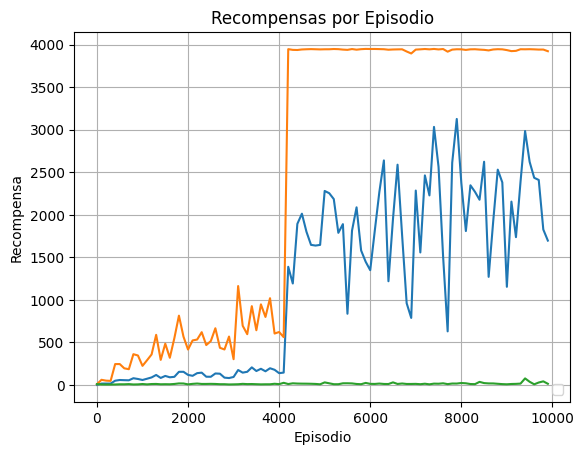

In [25]:
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'])#, label="average rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'])#, label="max rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'])#, label="min rewards")
plt.legend(loc=4)
plt.xlabel('Episodio')
plt.ylabel('Recompensa')
plt.title('Recompensas por Episodio')
plt.grid(True)
plt.show()

In [26]:
# Función para plotear y guardar el mapa de calor de la Q-table
def plot_q_table(episode):
    q_table = np.load(f"qtables/{episode}-qtable.npy")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'Q-table Heatmaps at Episode {episode}', fontsize=16)

    actions = ['Left', 'None', 'Right']
    for i, ax in enumerate(axes):
        heatmap = ax.imshow(q_table[:, :, i], cmap='viridis', aspect='auto')
        ax.set_title(f'Action: {actions[i]}')
        ax.set_xlabel('Theta_dot_dot')
        ax.set_ylabel('Theta')
        fig.colorbar(heatmap, ax=ax)

    plt.savefig(f"images/q_table_{episode}.png")
    plt.close(fig)

# Llamar a la función para crear los gráficos y guardar las imágenes
for episode in range(0, num_episodes, 100):
    plot_q_table(episode)

# Función para crear un video a partir de las imágenes
def create_video(image_folder, video_name, fps=10):
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    images.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))  # Ordenar por número de episodio
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    video.release()

# Crear el video a partir de las imágenes guardadas
create_video('images', 'q_table_evolution.mp4')